# Mini-project n° 2 – Conditional VAEs

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## VAE Standards VS. VAE Conditionnels

Les Autoencodeurs Variationnels Conditionnels (VAEs Conditionnels) s'appuient, tout comme les VAE standards, sur un modèle : encodeur  - décodeur avec compression des données dans un espace latent intermédiaire.

La principale différence est l'introduction d'entrées conditionnelles qui permettent au modèle de générer des échantillons de données en fonction de conditions ou d'attributs spécifiques. L'espace latent est lui même un espace latent conditionnel, la distribution de la variable latente $z$ dépendant de ces attributs.

Les informations présentées dans ce projet proviennent des sources suivantes:

- Nicolas Thome, Clément Rambour, Nicolas Audebert. Auto-encodeurs variationnels. Cnam. https://cedric.cnam.fr/vertigo/cours/RCP211/auto-encodeurs-variationnels.html. 2023.
- Nicolas Thome, Clément Rambour, Nicolas Audebert. Auto-encodeurs variationnels. Cnam. https://cedric.cnam.fr/vertigo/cours/RCP211/TP8-CVAE_PixelCNN.html. 2024
- Joseba Dalmau. Autoencoders and Variational Autoencoders. 2024


### VAE standards

En effet, dans un modèle de VAE "classique" le modèle de génération des données est obtenu via la formule suivante : 

$p(x) = \int p(x|z) p(z) dz$, intégrale difficile à calculer. On cherche alors plutôt à approximer $p(z|x)$ $\Bigl($ avec $p(z|x) = \frac{p(x|z) p(z)}{p(x)} \Bigr)$ qu'on ne connaît pas non plus mais qu'on veut approximer par une autre distribution $q(z|x)$.

Pour choisir $q(z|x)$, on veut s’approcher au maximum du véritable postérieur $p(z|x)$. On cherche pour cela à trouver les paramètres de $q $ qui minimisent l’écart entre les deux distributions. Le choix le plus courant pour mesurer cet écart est de calculer la divergence de Kullback-Leibler entre les deux probabilités, donnée par la formule suivante : 

$$KL(q(x)||p(x)) = \mathbb{E}_{q}(x)[log \:q(x)−log \:p(x)]$$

Minimiser cette divergence revient en fait à maximiser l'expression :

$$\mathbb{E}_{q(z|x)}[log \:p(x|z)]−KL(q(z|x)||p(z))$$

Ce terme est maximisé lorsque l'on a :

1- la maximisation de la log-vraisemblance, c’est-à-dire que les variables latentes $z$ permettent de prédire correctement x <br>
2- la minimisation d’une pénalité correspondant à la divergence entre $q$ et l'a priori $p$

### VAE conditionnels

Dans un VAE conditionnel, on l'a dit précédemment, la variable latente $z$ est condtionnée par c. Nous avons donc un espace latent et une distribution $p(z)$
différents pour chaque valeur du conditionnement c. Dans ce cas là, l'expression que l'on cherche alors  à minimiser est la suivante :

$$\mathbb{E}_{q(z|x,c)}[log \:p(x|z,c)]−KL(q(z|x,c)||p(z|c))$$


## Listes des hyperparamètres

Les hyperparamètres de notre modèle sont : 

- batch size = Le nombre d'échantillons sur lesquels le modèle apprend avant de mettre à jour ses paramètres internes (poids du réseau...)
- epochs = Le nombre de fois où l'entièreté du jeu de données est utilisée pour l'apprentissage. Une valeur trop faible peut conduire à du sous-apprentissage et au contraire une valeur trop élevée à du surapprentissage
- latent_dim = La taille de l'espace latent
- learning_rate = Le taux d'apprentissage. Il contrôle la vitesse à laquelle le modèle apprend.
- kl_weights = La liste des poids pour la divergence KL (Kullback-Leibler)
- beta = Ajuste l'importance de la divergence dans la fonction de perte

La fonction de perte utilisée ci-après est définie de la manière suivante :

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>
où BCE correspond à la "Binary Cross-Entropy" et KLD est la Divergence KL

Le premier terme est un terme de reconstruction : il mesure à quel point le réseau reconstruit correctement les données d’origine à partir de l’espace latent.
Le second terme est un terme de régularisation : il mesure à quel point la distribution de l'espace latent se rapproche d'une loi normale centrée réduite.

Ainsi, 3 cas sont à distinguer concernant le paramètre beta :

- beta = 1 : On accorde autant d'importance à la reconstruction qu'à la régularisation.
- beta > 1 : On donne davantage de poids à la régularisation. On fait en sorte que la distribution de l'espace latent se rapproche au plus d'une gaussienne centrée réduite. Cependant, cela peut diminuer la capacité de reconstruction du modèle.
- beta < 1 : On donne davantage de poids à la reconstruction. Le modèle apprend ainsi à capturer plus de détails dans l'image. Cependant, cela peut augmenter le risque de surapprentissage.

In [2]:
# Liste des hyperparamètres
batch_size = 128
epochs = 5
latent_dim = 2
learning_rate = 1e-3
kl_weights = [0.5, 1, 10, 100]
beta = 1

# Autres paramètres
nb_classes=10

nb_classes correspond au nombre de classes pouvant être générées par le modèle, en l'occurence 10 vêtements et accessoires.

## Chargement des données

In [3]:
# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:08<00:00, 3.01MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 843kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.44MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [27]:
print("Nombre d'images dans le jeu de données d'apprentissage :", len(train_dataset))
print("Nombre d'images dans le jeu de données test :", len(test_dataset))


Nombre d'images dans le jeu de données d'apprentissage : 60000
Nombre d'images dans le jeu de données test : 10000


## Création d'un modèle d'AutoEndodeur Variationnel Conditionnel (Conditionnal VAE)

Le modèle de VAE conditionnel utilisé par la suite se construit de la manière suivante :

- **Un Encodeur** : 
    - Une couche de convolution composée de 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 64 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 128 filtres, un noyau de taille 3, un stride de 2 et un padding de 1..
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.

- **Un Espace Latent** :

Il est composé de deux couches parallèles dites "entièrement connectées" (en d'autres termes tous les neurones sont connectés à ceux de la couche précédente, qui est ici la sortie de l'encodeur E(x)).

- La première couche estime un vecteur moyenne µ(x)
- La seconde couche estime un vecteur de log-variance $\log\sigma^2(x)$

Une dernière couche entièrement connectée utilise alors ces informations pour renvoyer la variable latente z selon une distribution gaussienne : $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ 

- **Un Décodeur.** 
    - Une couche de déconvolution composée de 64 filtres, un noyau de taille 3, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 1 filtre, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une fonction d'activation Sigmoïde

**Au niveau de l'encodeur :**

Pour chacune des couches de convolution :
- Un filtre (ou noyau) est une matrice de poids qui parcourt l’image d’entrée pour extraire des caractéristiques spécifiques (de manière générale comme des contours ou des textures). La sortie de la couche est obtenue à partir d'une convolution entre l'objet en entrée et le filtre. Le paramètre kernel_size désigne la taille de la matrice.
- Un filtre apprend UNE caractéristique de l’image donc, plus il y a de filtres, plus le modèle retient de caractéristiques.
- Le stride indique de combien de pixels le filtre se déplace à chaque étape lorsqu’il parcourt l’image d’entrée (d'abord horizontalement puis verticalement). 
- Le padding consiste à ajouter des pixels autour de l'image pour essayer de préserver l'information sur les bords de l'image. Un padding de 1 signfie que l'on ajoute une rangée de pixel tout autour de l'image

L’augmentation progressive du nombre de filtres dans les couches de convolution permet de capturer des caractéristiques de plus en plus complexes des données d’entrée : les couches proches de l'entrée capturent des motifs de base et au fur et à mesure que l’on avance dans le réseau, on veut que chaque couche représente des détails plus sophistiqués. Avoir plus de filtres permet à chaque couche de détecter des motifs plus variés et spécifiques.

La couche BatchNorm permet de normaliser les sorties d'une couche de réseau lors de l'apprentissage.

**Au niveau du décodeur :**

La fonction d'activation utilisée en sortie est la fonction Sigmoïde. Elle renvoie des valeurs comprises entre 0 et 1 , ce qui est utile puisqu' avec ce réseau on cherche à générer des images en noir et blanc. Les résultats obtenus permettent donc directement d'obtenir des nuances de gris.




**Le vecteur de conditionnement c** :

Donne une information/une étiquette sur les données. Ici c indique la valeur numérique associée à une image du jeu de données (ie le numéro de la classe représentée).
La variable latente z est alors conditionnée par c.

In [4]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) # (128*4*4) est la taille de sortie de la couche précédente
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # "Applatissement" de la sortie après convolution (on restructure les donnes pour que x et c soient de meme taille)
        x = torch.cat((x,c),dim=1) # Concaténation de x et c
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def latent_sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z = torch.cat((z,c),dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.latent_sample(mu, logvar)
        return self.decode(z, c), mu, logvar

### Création de la fonction de perte (loss function)

La formule de la fonction de perte est celle donnée précédemment : 

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>

L'objectif est d'avoir un bon compromis entre reconstruction et régularisation.

Pour le terme de reconstruction, on utilise la "Binary Cross-entropy" afin d'accentuer les contrastes (on oblige les pixels à prendre des valeurs très proches de 0 ou de 1 et donc à avoir des zones de l'image très blanches et d'autres très noires).

In [5]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # terme de reconstruction 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # terme de regularisation (on cherche à se rapprocher d'une loi normale)
    return BCE + beta * KLD

In [6]:
# On utilise la même fonction de perte mais cette fois-ci on renvoie séparément la valeur de la loss, de la cross-entropy et de la divergence
def loss_function_sep(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

## Apprentissage "naïf" du modèle de VAE conditionnel

Dans un premier temps, on effectue un travail "naïf" pour l'apprentissage et la génération d'images. En d'autres termes, on utilise des valeurs non-optimisées de nos hyperparamètres afin d'avoir un premier aperçu du fonctionnement de notre modèle.

Epoch 1, Training loss: 273.2754, BCE: 268.7874, KLD: 4.4880
Epoch 2, Training loss: 257.9263, BCE: 253.2314, KLD: 4.6949
Epoch 3, Training loss: 256.4248, BCE: 251.6981, KLD: 4.7266
Epoch 4, Training loss: 255.3914, BCE: 250.6400, KLD: 4.7513
Epoch 5, Training loss: 254.6258, BCE: 249.8667, KLD: 4.7591


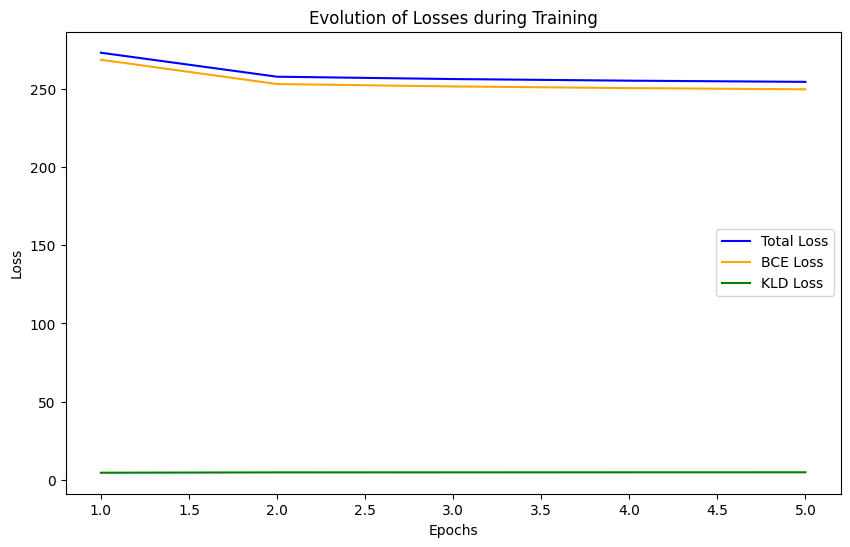

In [16]:
import matplotlib.pyplot as plt

# Initialisation du modèle VAE
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Listes pour stocker les pertes de chaque époque
total_losses = []
bce_losses = []
kld_losses = []

# Entraînement du modèle
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    running_bce = 0.0
    running_kld = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss, bce, kld = loss_function_sep(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        # Mise à jour des pertes
        running_loss += loss.item()
        running_bce += bce.item()
        running_kld += kld.item()
    
    # Calcul des pertes moyennes par époque
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_bce = running_bce / len(train_loader.dataset)
    epoch_kld = running_kld / len(train_loader.dataset)

    # Affichage de la perte par époque
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')
    
    # Enregistrement des pertes
    total_losses.append(epoch_loss)
    bce_losses.append(epoch_bce)
    kld_losses.append(epoch_kld)

# Visualisation des courbes de perte
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), total_losses, label="Total Loss", color='blue')
plt.plot(range(1, epochs + 1), bce_losses, label="BCE Loss", color='orange')
plt.plot(range(1, epochs + 1), kld_losses, label="KLD Loss", color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of Losses during Training')
plt.legend()
plt.show()


### Génération des images

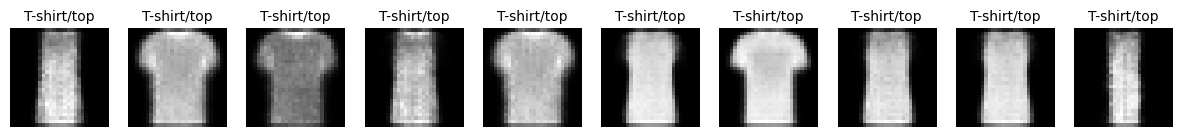

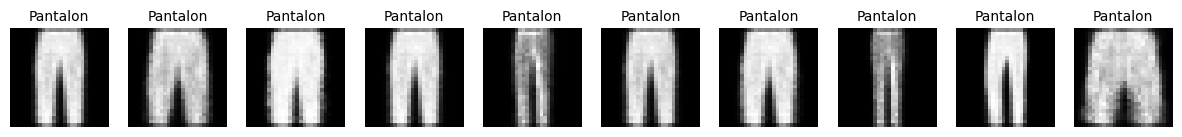

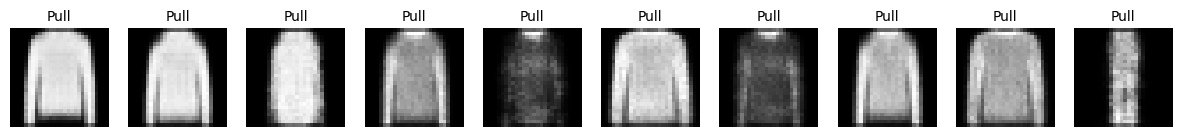

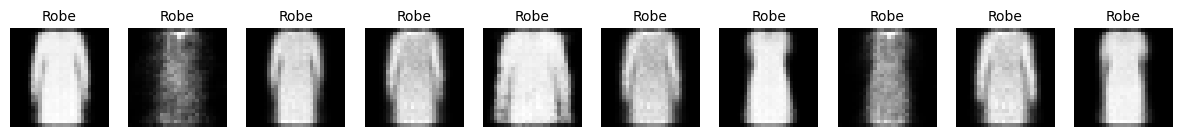

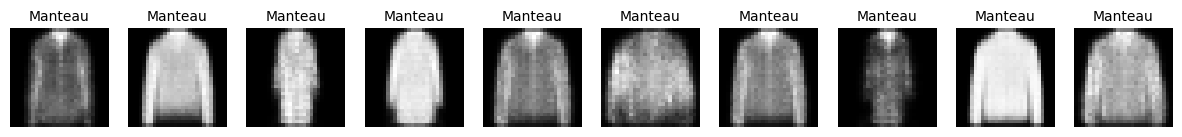

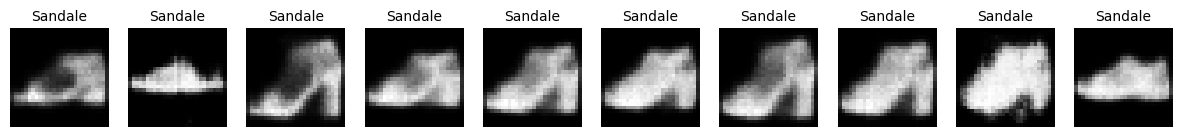

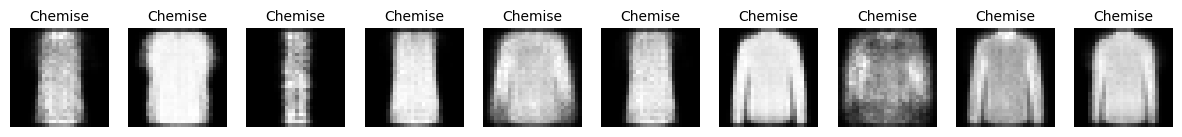

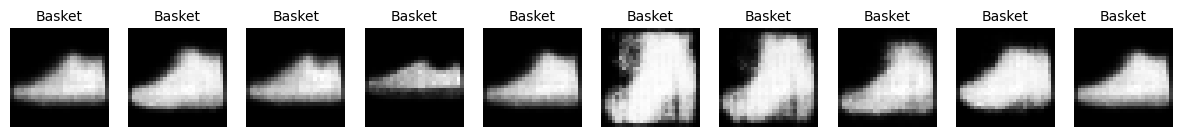

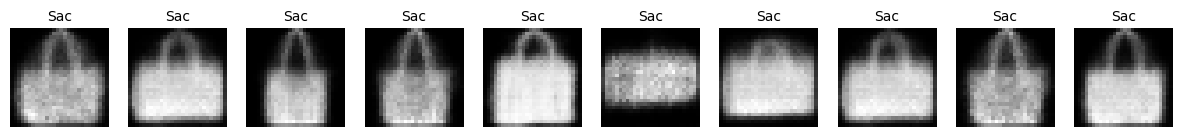

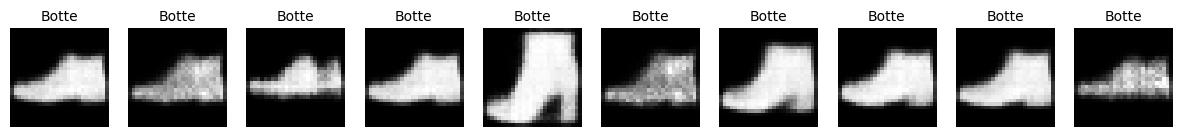

In [17]:
def generate_sample(num_samples=10, objet="robe"):
# digit est la valeur conditionelle c'est-à-dire la classe que l'on veut générer
    vae.eval()
    with torch.no_grad():

        # Échantillonage selon une loi normale
        z = torch.randn(num_samples, latent_dim).to(device)

        # On ajoute la condition ie la valeur que l'on veut générer
        condition = torch.zeros(num_samples,10, dtype=int).to(device)
        condition[:, objet] = 1 # indique que c'est la valeur digit que l'on cherche à générer

        # On génère l'image
        samples = vae.decode(z, condition)
        samples = samples.cpu().view(num_samples, 1, 28, 28)

        class_names = [
            "T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau",
            "Sandale", "Chemise", "Basket", "Sac", "Botte"
        ]

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
            ax[i].set_title(class_names[objet], fontsize=10)
        plt.show()


for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

In [13]:
def evaluate_model(test_loader):
    vae.eval()  # Passage en mode évaluation
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            recon_batch, mu, logvar = vae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar, beta)  # Fonction de perte utilisée lors de l'entraînement
            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {average_test_loss:.4f}')


In [18]:
evaluate_model(test_loader)

Test Loss: 257.1277


La fonction de perte a une valeur similaire à la dernière valeur obtenue lors de l'apprentissage. Il ne semble donc pas y avoir de surapprentissage.

### Visualisation de l'espace latent


Training VAE with KL Weight = 0.5
Epoch 1: Average Loss: 279.3807, BCE: 276.1960, KLD: 6.3693
Epoch 2: Average Loss: 255.1713, BCE: 252.2073, KLD: 5.9281
Epoch 3: Average Loss: 253.3066, BCE: 250.3476, KLD: 5.9180
Epoch 4: Average Loss: 252.4844, BCE: 249.5143, KLD: 5.9402
Epoch 5: Average Loss: 251.9086, BCE: 248.9445, KLD: 5.9281


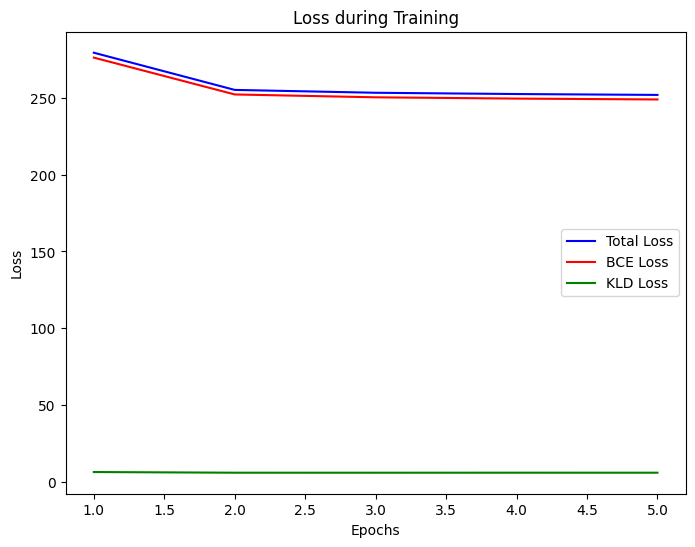

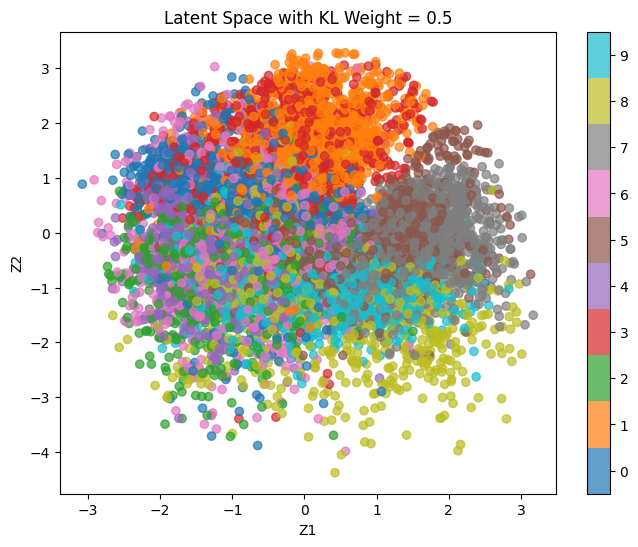


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 273.5202, BCE: 268.5073, KLD: 5.0128
Epoch 2: Average Loss: 257.6526, BCE: 252.6092, KLD: 5.0435
Epoch 3: Average Loss: 256.1046, BCE: 251.0816, KLD: 5.0230
Epoch 4: Average Loss: 255.2827, BCE: 250.2768, KLD: 5.0060
Epoch 5: Average Loss: 254.3775, BCE: 249.3940, KLD: 4.9834


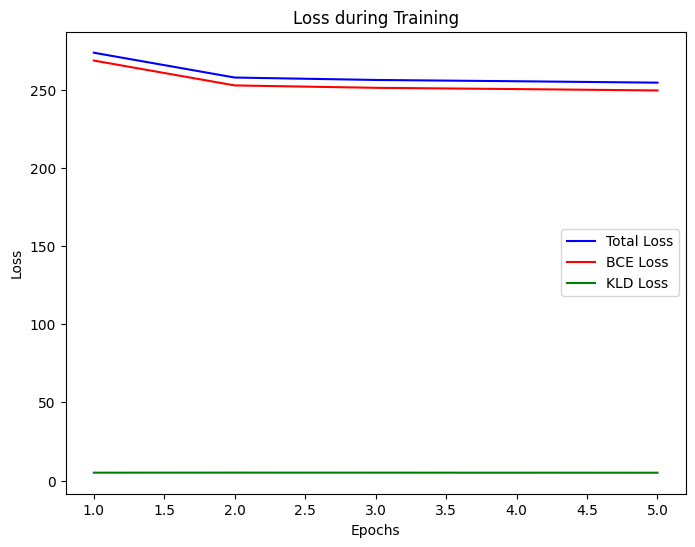

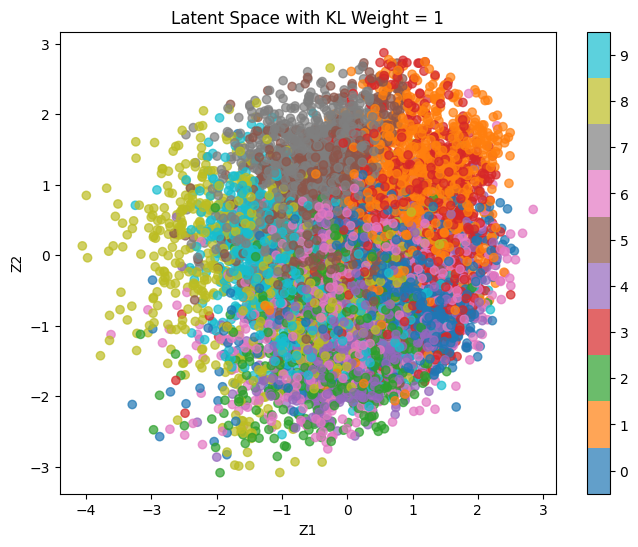


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 294.9818, BCE: 278.8112, KLD: 1.6171
Epoch 2: Average Loss: 283.1651, BCE: 266.1688, KLD: 1.6996
Epoch 3: Average Loss: 281.4589, BCE: 264.2246, KLD: 1.7234
Epoch 4: Average Loss: 280.3004, BCE: 262.9554, KLD: 1.7345
Epoch 5: Average Loss: 279.6165, BCE: 262.2303, KLD: 1.7386


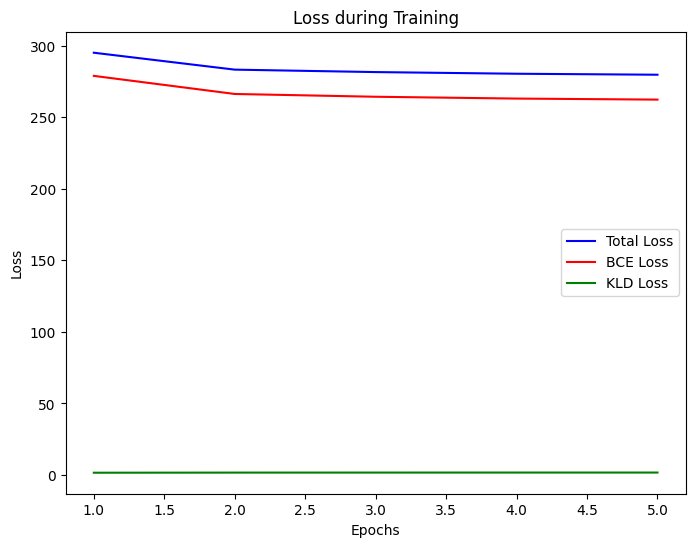

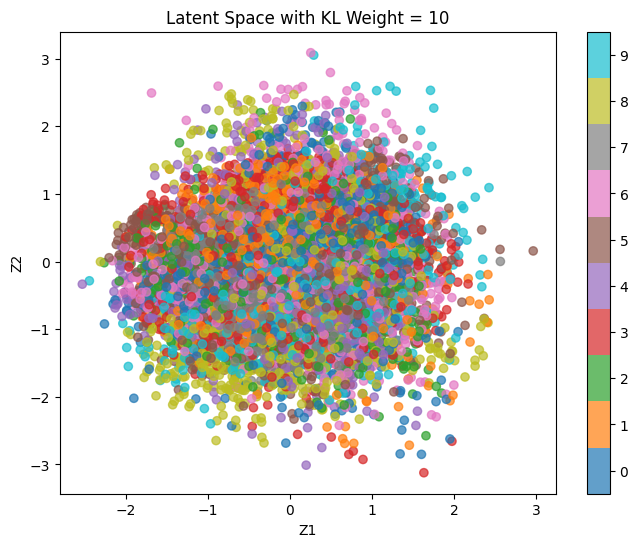


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 320.2542, BCE: 318.4201, KLD: 0.0183
Epoch 2: Average Loss: 308.1961, BCE: 308.0429, KLD: 0.0015
Epoch 3: Average Loss: 307.8169, BCE: 307.6890, KLD: 0.0013
Epoch 4: Average Loss: 307.7479, BCE: 307.6324, KLD: 0.0012
Epoch 5: Average Loss: 307.6732, BCE: 307.5835, KLD: 0.0009


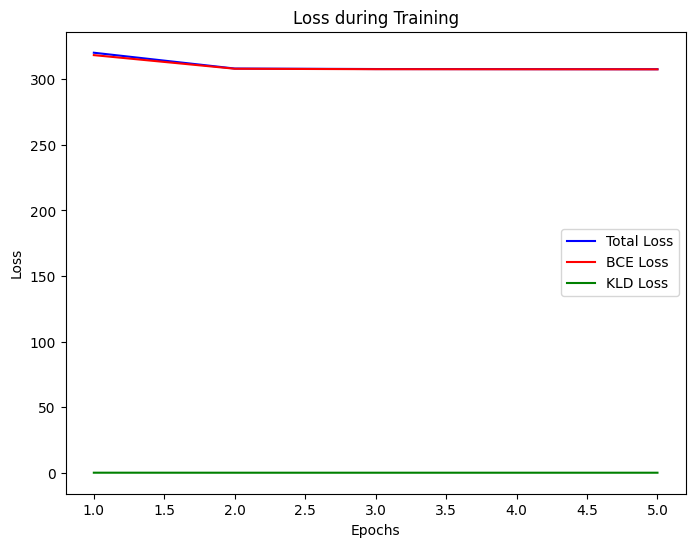

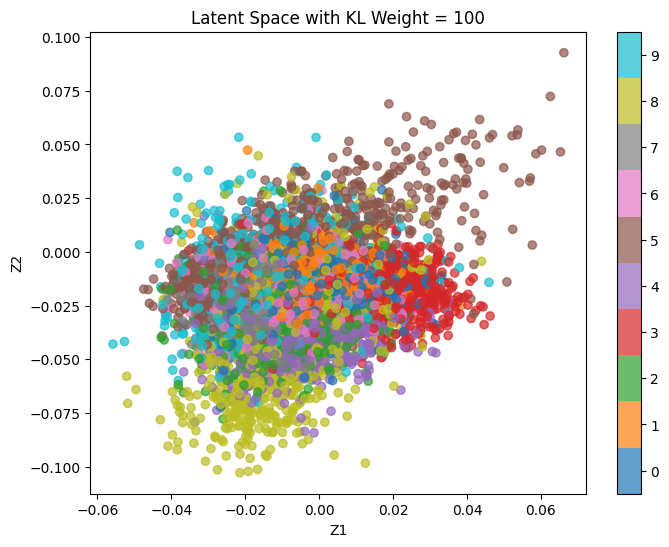

In [15]:
def train_and_plot(kl_weight):
    model = ConvVAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    bce_losses = []
    kld_losses = []
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function_sep(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        
        # Stockage des valeurs pour la visualisation après l'entraînement
        train_losses.append(average_loss)
        bce_losses.append(average_bce)
        kld_losses.append(average_kld)
        
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Visualisation de la perte
    plot_loss(train_losses, bce_losses, kld_losses)
    
    # Visualisation de l'espace latent
    plot_latent_space(model, kl_weight)


def plot_loss(train_losses, bce_losses, kld_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Total Loss', color='blue')
    plt.plot(range(1, len(bce_losses) + 1), bce_losses, label='BCE Loss', color='red')
    plt.plot(range(1, len(kld_losses) + 1), kld_losses, label='KLD Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss during Training')
    plt.legend()
    plt.show()

def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)

        mu, logvar = model.encode(data, labels)
        z = mu  # Pour la visualisation on utilise la moyenne
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=np.argmax(labels, axis=1), cmap='tab10', alpha=0.7)  # On utilise np.argmax pour obtenir les classes
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()


# Visualisation de l'espace latent en fonction de la valeur de la divergence
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)



Training VAE with KL Weight = 0.5
Epoch 1: Average Loss: 270.0610, BCE: 267.0968, KLD: 5.9285
Epoch 2: Average Loss: 254.5901, BCE: 251.5922, KLD: 5.9959
Epoch 3: Average Loss: 252.9300, BCE: 249.9422, KLD: 5.9755
Epoch 4: Average Loss: 252.2641, BCE: 249.2880, KLD: 5.9523
Epoch 5: Average Loss: 251.5556, BCE: 248.5839, KLD: 5.9432


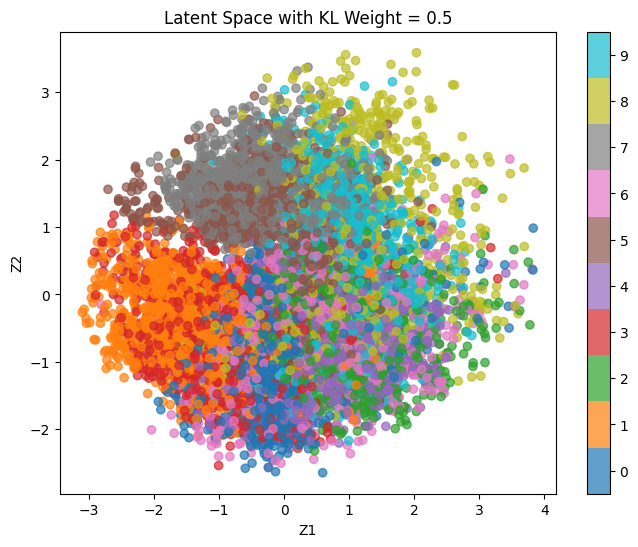


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 273.4910, BCE: 268.4210, KLD: 5.0700
Epoch 2: Average Loss: 257.4650, BCE: 252.3925, KLD: 5.0725
Epoch 3: Average Loss: 256.0015, BCE: 250.9595, KLD: 5.0421
Epoch 4: Average Loss: 254.9335, BCE: 249.9294, KLD: 5.0042
Epoch 5: Average Loss: 254.3402, BCE: 249.3436, KLD: 4.9966


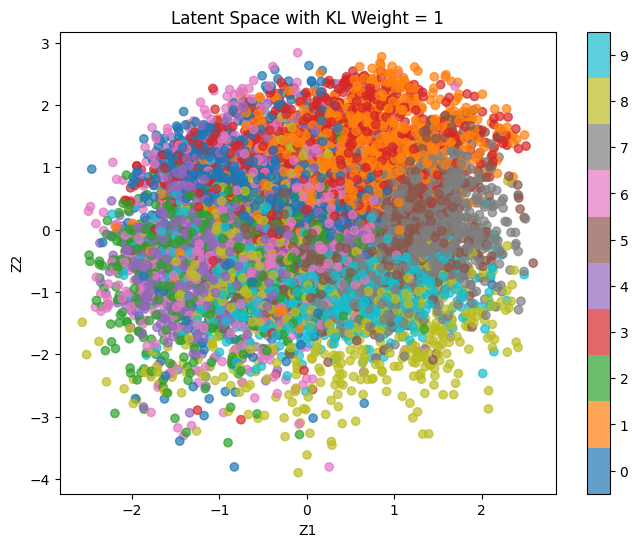


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 297.4038, BCE: 282.3122, KLD: 1.5092
Epoch 2: Average Loss: 283.5201, BCE: 266.8939, KLD: 1.6626
Epoch 3: Average Loss: 281.5341, BCE: 264.5231, KLD: 1.7011
Epoch 4: Average Loss: 280.5148, BCE: 263.2990, KLD: 1.7216
Epoch 5: Average Loss: 279.7102, BCE: 262.3637, KLD: 1.7346


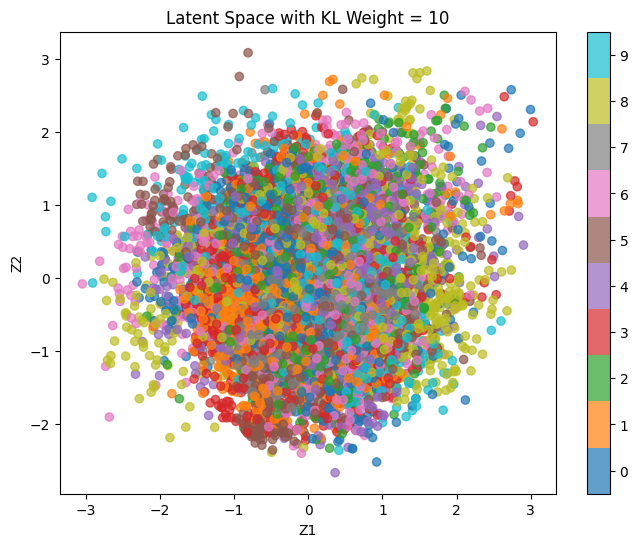


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 320.5534, BCE: 317.8576, KLD: 0.0270
Epoch 2: Average Loss: 308.1363, BCE: 307.9999, KLD: 0.0014
Epoch 3: Average Loss: 307.8358, BCE: 307.7341, KLD: 0.0010
Epoch 4: Average Loss: 307.6803, BCE: 307.5897, KLD: 0.0009
Epoch 5: Average Loss: 307.6154, BCE: 307.5157, KLD: 0.0010


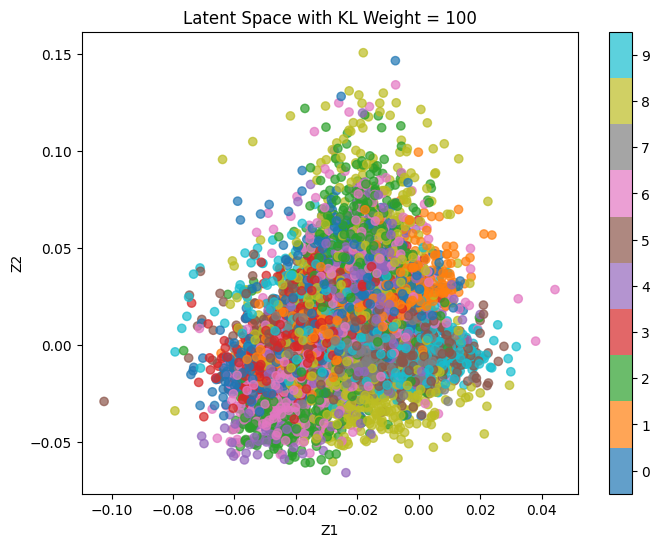

In [9]:
# Apprentissage du modèle en fonction de la divergence
def train_and_plot(kl_weight):
    model = ConvVAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function_sep(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Visualisation de l'espace latent
    plot_latent_space(model, kl_weight)


def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)

        mu, logvar = model.encode(data, labels)
        z = mu  # Pour la visualisation on utilise la moyenne
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=np.argmax(labels, axis=1), cmap='tab10', alpha=0.7)  # On utilise np.argmax pour obtenir les classes
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()


# Visualisation de l'espace latent en fonction de la valeur de la divergence
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)

En théorie, plus la valeur de la divergence augmente, plus on accentue la régularisation, c'est-à-dire que le modèle cherche davantage à ce que z1 et z2 s'approche d'une loi gaussienne et de fait, il est normal que les classes se distinguent moins les unes des autres.
C'est effectivement ce qui se passe ici : plus la valeur de la divergence est élevée et plus il y a enchevêtrement des classes.

Pour les plus faibles valeurs de KL (on donne alors plus de poids à la reconstruction), les classes se distinguent davantage les unes des autres mais il y a tout de même beaucoup de superpositions.

## Optimisation des paramètres et nouvelle génération d'images

L'objectif de cette section est de tester différentes combinaisons d'hyperparamètres afin de déterminer celle qui est la plus optimale. Pour cela, pour chaque combinaison on calcule la valeur de la fonction de perte obtenue à la fin de l'apprentissage. On regarde alors quelle combinaison nous permet d'avoir une valeur minimale. Nos images seront ensuite générées avec cette combinaison d'hyperparamètres.

Afin de limiter les temps de calcul, 3 valeurs ont été testées pour chaque hyperparamètre que l'on a voulu optimiser.

### Recherche des paramètres optimaux

In [ ]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2]

def Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    combinations = list(itertools.product(batch_size_list, epochs_list, latent_dim_list, beta_list))
    loss_list = []
    param_list = []

    for batch_size_opt, epochs_opt, latent_dim_opt, beta_opt in  combinations:
        train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)
        test_loader_opt = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_opt, shuffle=False)

        # Initialisation du modèle de VAE model
        vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
        vae.to(device)
        optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
        # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

        # On entraîne le modèle sur chaque epoch
        for epoch in range(1, epochs_opt + 1):
            vae.train()
            running_loss = 0.0
            for batch_idx, (data, labels) in enumerate(train_loader_opt):
                data = data.to(device)
                labels = F.one_hot(labels, num_classes=nb_classes).to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = vae(data, labels)
                loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader_opt.dataset)
        loss_list.append(epoch_loss)
        param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])

    print(f"Valeur minimale de la fonction de perte : {min(loss_list)}, pour les paramètres suivants :")
    print(f"batch_size_opt : {param_list[loss_list.index(min(loss_list))][0]}")
    print(f"epochs_opt : {param_list[loss_list.index(min(loss_list))][1]}")
    print(f"latent_dim_opt : {param_list[loss_list.index(min(loss_list))][2]}")
    print(f"beta_opt : {param_list[loss_list.index(min(loss_list))][3]}")


In [24]:
Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list)

Valeur minimale de la fonction de perte : 224.15730145670574, pour les paramètres suivants :
batch_size_opt : 64
epochs_opt : 50
latent_dim_opt : 64
beta_opt : 0.5


### Influence des différents paramètres

On va ensuite chercher à voir l'influence de chaque paramètre sur les valeurs de la fonction de perte. Cette fois-ci, pour chaque graphe obtenu, 3 des 4 paramètres sont fixés tandis que le troisème varie.

In [6]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2]

def apprentissage(batch_size_opt, epochs_opt, latent_dim_opt, beta_opt):
    loss_list = []
    param_list = []

    train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)

    # Initialisation du modèle de VAE model
    vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
    # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

    # On entraîne le modèle sur chaque epoch
    for epoch in range(1, epochs_opt + 1):
        vae.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader_opt):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader_opt.dataset)
    loss_list.append(epoch_loss)
    param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])
    return(loss_list, param_list)




def Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    xb = []
    lossb = []
    xe = []
    losse = []
    xl = []
    lossl = []
    xbe = []
    lossbe = []
    
    for batch_opt in batch_size_list :
        torch.cuda.empty_cache()
        loss_batch, param_batch = apprentissage(batch_opt, epochs, latent_dim, beta)
        xb.append(batch_opt)
        lossb.append(loss_batch)

    plt.plot(xb, lossb, label='Fonction de perte pour des batchs différents')
    plt.xlabel('Batch')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for epochs_opt in epochs_list :
        torch.cuda.empty_cache()
        loss_epoch, param_epoch = apprentissage(batch_size, epochs_opt, latent_dim, beta)
        xe.append(epochs_opt)
        losse.append(loss_epoch)

    plt.plot(xe, losse, label='Fonction de perte pour des epochs différents')
    plt.xlabel('Epochs')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for latent_dim_opt in latent_dim_list :
        torch.cuda.empty_cache()
        loss_latent, param_latent = apprentissage(batch_size, epochs, latent_dim_opt, beta)
        xl.append(latent_dim_opt)
        lossl.append(loss_latent)

    plt.plot(xl, lossl, label='Fonction de perte pour des espaces latents différents')
    plt.xlabel('Espaces Latents')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for beta_opt in beta_list :
        torch.cuda.empty_cache()
        loss_beta, param_beta = apprentissage(batch_size, epochs, latent_dim, beta_opt)
        xbe.append(beta_opt)
        lossbe.append(loss_beta)

    plt.plot(xbe, lossbe, label='Fonction de perte pour des beta différents')
    plt.xlabel('Beta')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()
    

On fixe initialement nos paramètres en utilisant les valeurs optimales calculées précédemment et à chaque fois on ne fait varier qu'un seul des quatre paramètres.

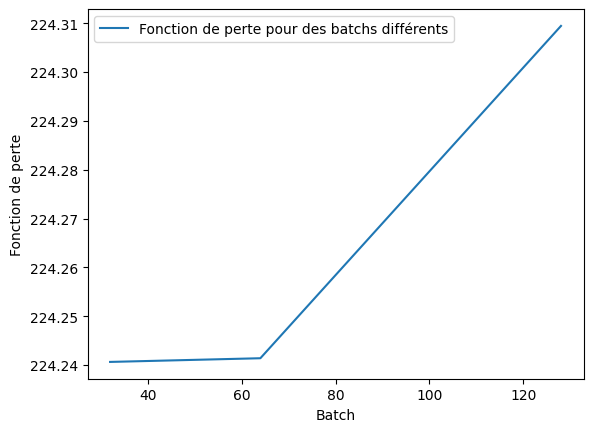

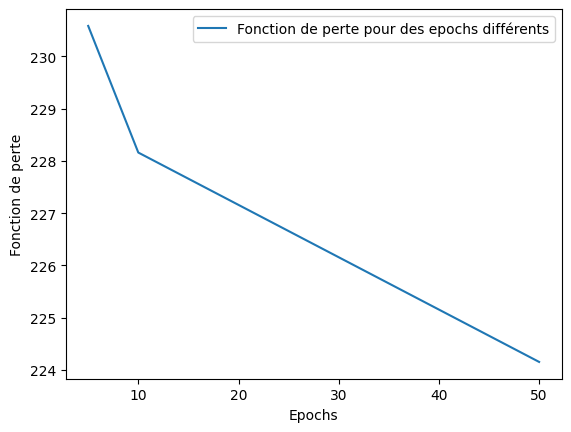

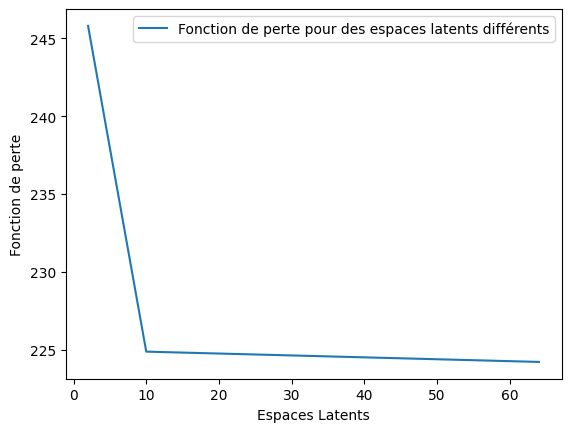

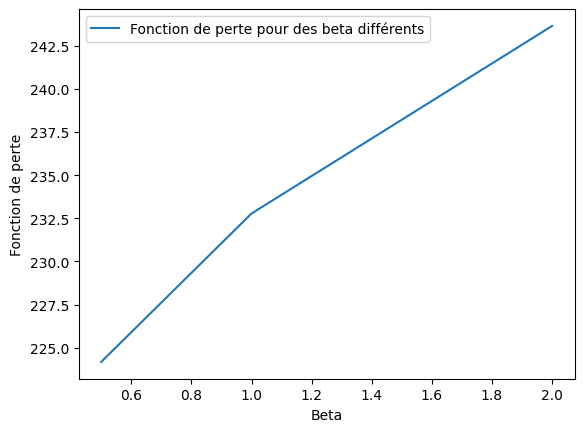

In [7]:
# Liste des hyperparamètres optimaux
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list)

Les résultats obtenus permettent de conclure de la manière suivante :

- La taille du batch semble avoir peut d'influence sur les valeurs de la fonction perte.
- En revanche, les trois autres paramètres influencent fortement les valeurs de la fonction de perte :
   - Plus le nombre d'epochs est grand, plus la fonction de perte est faible. Cela semble logique car le modèle utilise davantage l'ensemble de données pour l'apprentissage.
  - De même, plus la taille de l'espace latent est grande, plus la fonction de perte est faible. En fait, plus la taille de l'espace latent est grande, plus le modèle capture davantage de nuances et de détails dans les données.
  - Enfin, plus beta est faible, plus la fonction de perte est faible. Là encore cela semble logique puisqu'en utilisant un beta plus faible, on donne davantage de poids à la reconstruction.
 
Ainsi, en augmentant le nombre d'epochs et la taille de l'espace latent, et en diminuant beta, on améliore les valeurs de la fonction de perte mais on augmente le risque de surapprentissage. Cependant, faire ce choix nous permet de générer des images proches de ce qui est attendu pour chaque classe de vêtements (plus qu'avec d'autres choix de paramètres) et justifie que l'on ait décidé de travailler avec ces paramètres optimaux.

### Nouvelle génération d'images avec les paramètres optimisés

Epoch 1, Training loss: 259.5790, BCE: 246.1724, KLD: 26.8133
Epoch 2, Training loss: 237.4797, BCE: 225.0432, KLD: 24.8730
Epoch 3, Training loss: 234.0237, BCE: 221.6768, KLD: 24.6939
Epoch 4, Training loss: 232.2880, BCE: 220.0268, KLD: 24.5225
Epoch 5, Training loss: 231.1213, BCE: 218.9431, KLD: 24.3565
Epoch 6, Training loss: 230.3714, BCE: 218.2707, KLD: 24.2014
Epoch 7, Training loss: 229.6729, BCE: 217.6504, KLD: 24.0451
Epoch 8, Training loss: 229.1310, BCE: 217.1826, KLD: 23.8968
Epoch 9, Training loss: 228.7020, BCE: 216.8188, KLD: 23.7664
Epoch 10, Training loss: 228.3405, BCE: 216.4941, KLD: 23.6928
Epoch 11, Training loss: 228.0565, BCE: 216.2643, KLD: 23.5845
Epoch 12, Training loss: 227.7569, BCE: 216.0008, KLD: 23.5121
Epoch 13, Training loss: 227.5317, BCE: 215.8174, KLD: 23.4286
Epoch 14, Training loss: 227.2811, BCE: 215.5958, KLD: 23.3706
Epoch 15, Training loss: 227.0211, BCE: 215.3773, KLD: 23.2876
Epoch 16, Training loss: 226.9189, BCE: 215.2949, KLD: 23.2480
E

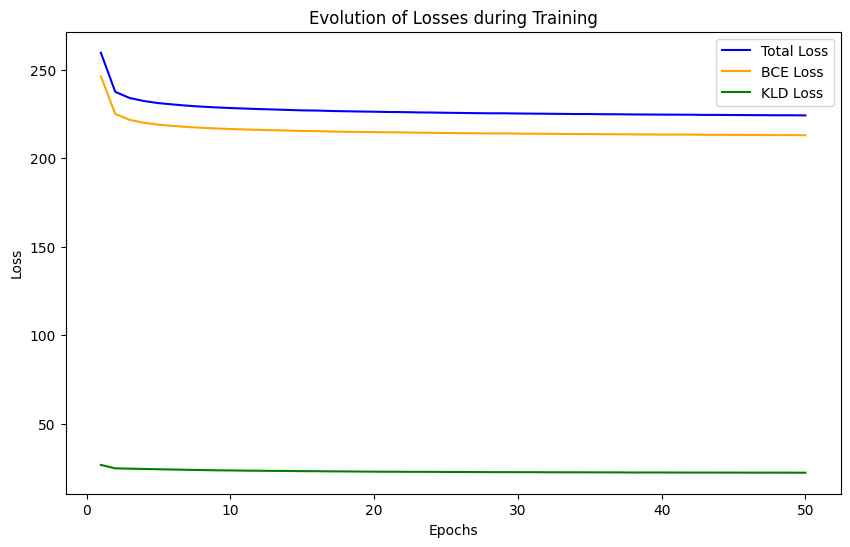

In [19]:
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

# Initialisation du modèle VAE avec les paramètres optimaux
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Listes pour stocker les pertes de chaque époque
total_losses = []
bce_losses = []
kld_losses = []

# Entraînement du modèle avec les paramètres optimaux
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    running_bce = 0.0
    running_kld = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss, bce, kld = loss_function_sep(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        # Mise à jour des pertes
        running_loss += loss.item()
        running_bce += bce.item()
        running_kld += kld.item()
    
    # Calcul des pertes moyennes par époque
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_bce = running_bce / len(train_loader.dataset)
    epoch_kld = running_kld / len(train_loader.dataset)

    # Affichage de la perte par époque
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')
    
    # Enregistrement des pertes
    total_losses.append(epoch_loss)
    bce_losses.append(epoch_bce)
    kld_losses.append(epoch_kld)

# Visualisation des courbes de perte
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), total_losses, label="Total Loss", color='blue')
plt.plot(range(1, epochs + 1), bce_losses, label="BCE Loss", color='orange')
plt.plot(range(1, epochs + 1), kld_losses, label="KLD Loss", color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of Losses during Training')
plt.legend()
plt.show()

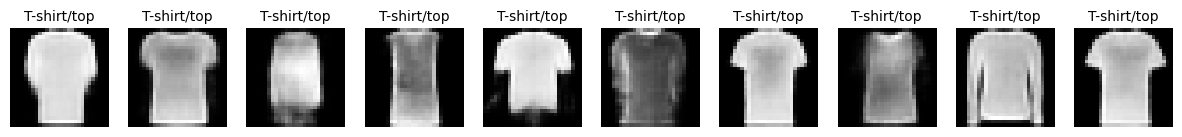

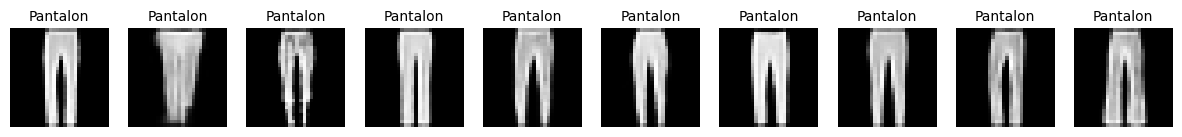

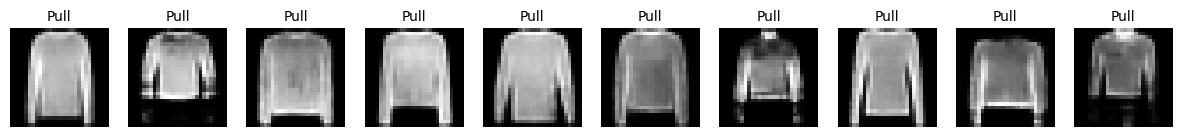

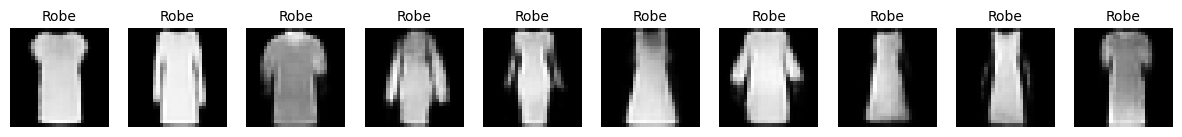

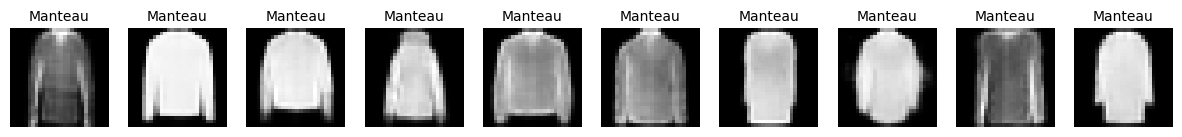

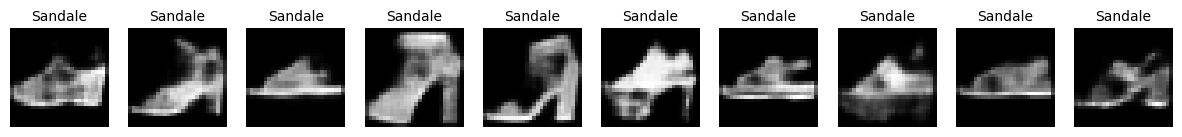

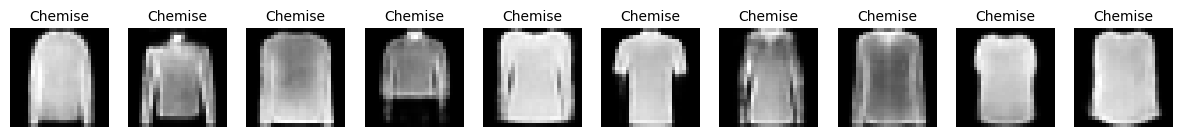

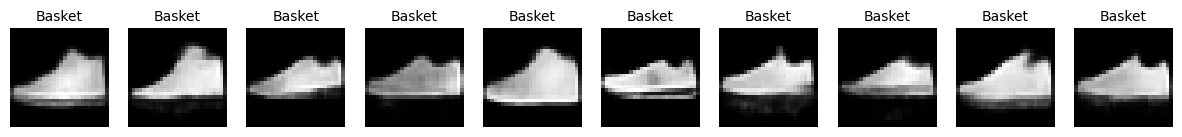

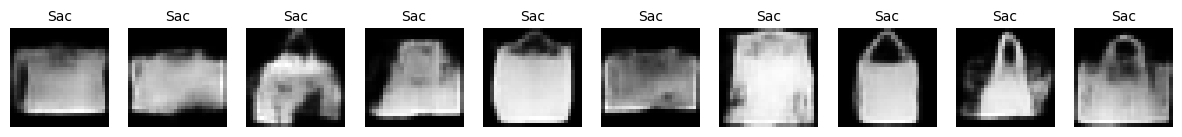

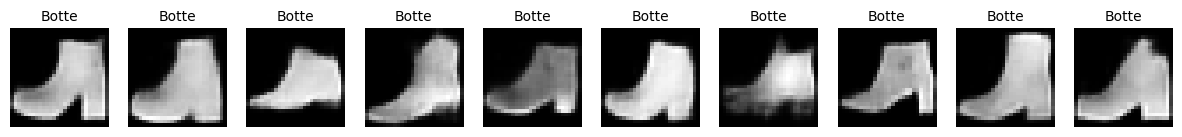

In [21]:
for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

In [22]:
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

# Initialisation du modèle de VAE model
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
# On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

# On entraîne le modèle sur chaque epoch
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}') # Affiche la fonction de perte

Epoch 1, Training loss: 260.1568
Epoch 2, Training loss: 237.3802
Epoch 3, Training loss: 234.1594
Epoch 4, Training loss: 232.3716
Epoch 5, Training loss: 231.2774
Epoch 6, Training loss: 230.4504
Epoch 7, Training loss: 229.8505
Epoch 8, Training loss: 229.2582
Epoch 9, Training loss: 228.8033
Epoch 10, Training loss: 228.4997
Epoch 11, Training loss: 228.1124
Epoch 12, Training loss: 227.8578
Epoch 13, Training loss: 227.5732
Epoch 14, Training loss: 227.3606
Epoch 15, Training loss: 227.1659
Epoch 16, Training loss: 226.9766
Epoch 17, Training loss: 226.7774
Epoch 18, Training loss: 226.6370
Epoch 19, Training loss: 226.4562
Epoch 20, Training loss: 226.3213
Epoch 21, Training loss: 226.1885
Epoch 22, Training loss: 226.0207
Epoch 23, Training loss: 225.9682
Epoch 24, Training loss: 225.8558
Epoch 25, Training loss: 225.7437
Epoch 26, Training loss: 225.6419
Epoch 27, Training loss: 225.5401
Epoch 28, Training loss: 225.4459
Epoch 29, Training loss: 225.3761
Epoch 30, Training loss

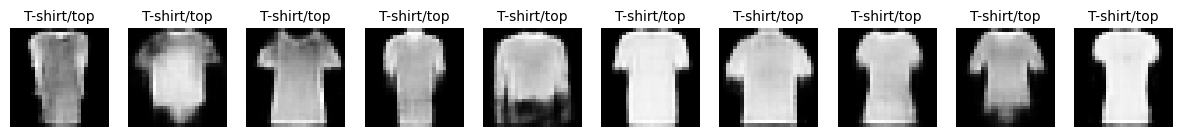

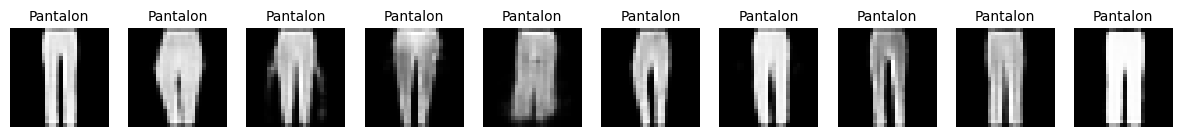

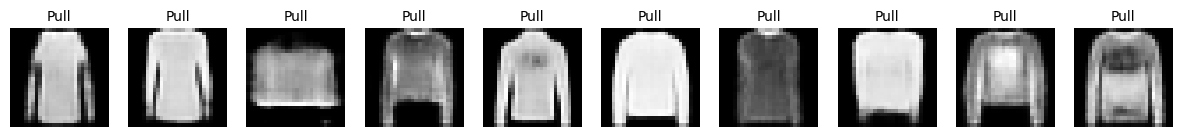

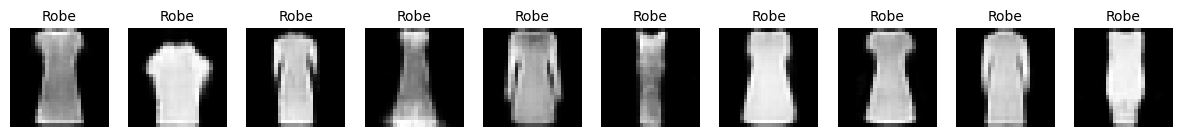

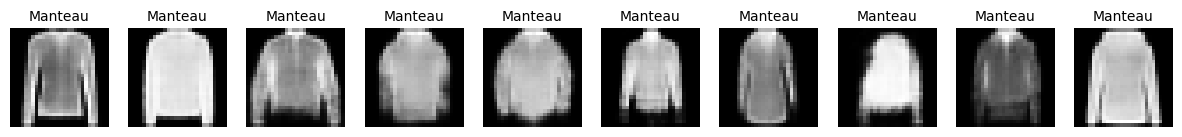

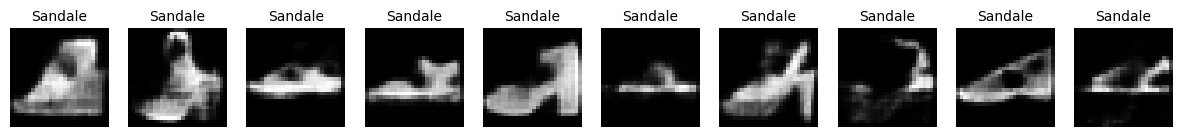

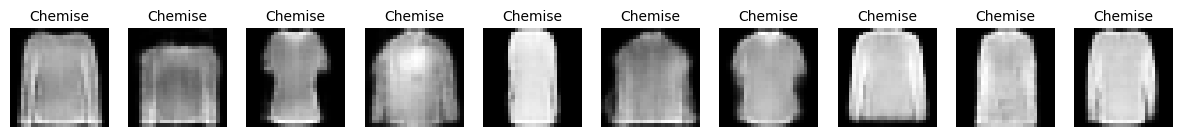

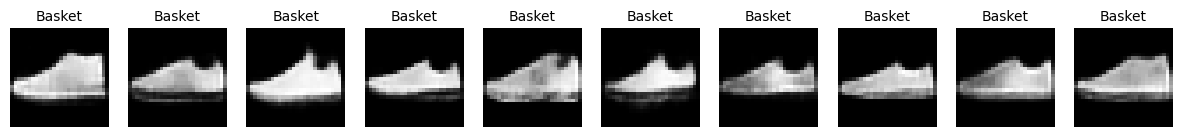

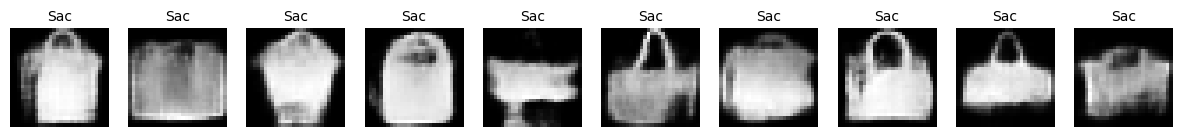

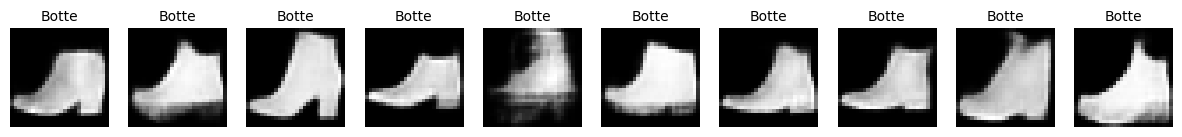

In [23]:
for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

### Capacité de généralisation

In [22]:
evaluate_model(test_loader)

Test Loss: 226.6845


Là encore la valeur de perte du test est proche de celle de la dernière itération de l'apprentissage mon trant les capacités de généralisation du modèle. Le choix des paramètres optimaux n'a donc pas entraîné de surapprentissage au final.

### Visualisation de l'espace latent


Training VAE with KL Weight = 0.5
Epoch 1: Average Loss: 267.4032, BCE: 254.0747, KLD: 26.6570
Epoch 2: Average Loss: 237.9086, BCE: 225.1333, KLD: 25.5506
Epoch 3: Average Loss: 234.4008, BCE: 221.7959, KLD: 25.2098
Epoch 4: Average Loss: 232.5429, BCE: 220.1043, KLD: 24.8771
Epoch 5: Average Loss: 231.4373, BCE: 219.1153, KLD: 24.6441
Epoch 6: Average Loss: 230.5289, BCE: 218.3294, KLD: 24.3989
Epoch 7: Average Loss: 229.8623, BCE: 217.7693, KLD: 24.1860
Epoch 8: Average Loss: 229.3112, BCE: 217.3017, KLD: 24.0189
Epoch 9: Average Loss: 228.8345, BCE: 216.9043, KLD: 23.8604
Epoch 10: Average Loss: 228.5038, BCE: 216.6571, KLD: 23.6935
Epoch 11: Average Loss: 228.1392, BCE: 216.3405, KLD: 23.5974
Epoch 12: Average Loss: 227.8696, BCE: 216.1217, KLD: 23.4958
Epoch 13: Average Loss: 227.5510, BCE: 215.8443, KLD: 23.4135
Epoch 14: Average Loss: 227.3045, BCE: 215.6271, KLD: 23.3548
Epoch 15: Average Loss: 227.1055, BCE: 215.4555, KLD: 23.3001
Epoch 16: Average Loss: 226.8957, BCE: 215.2

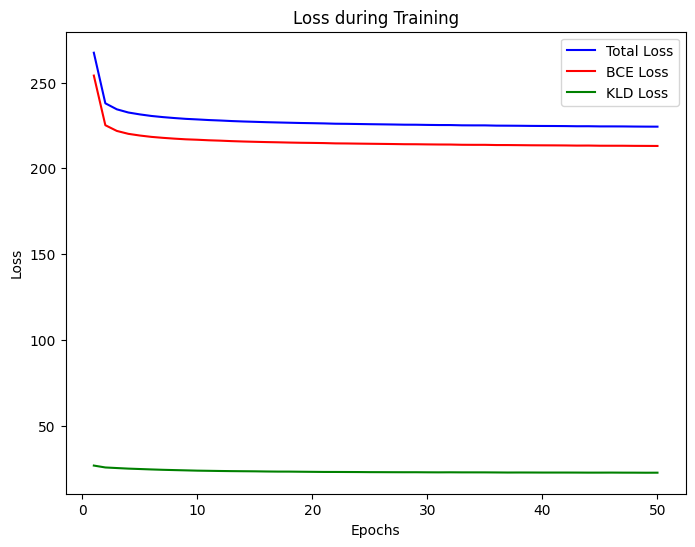

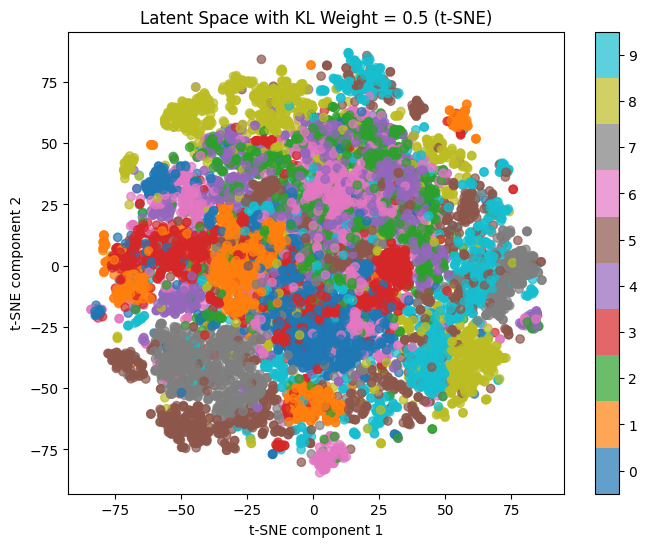


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 272.5635, BCE: 256.9747, KLD: 15.5887
Epoch 2: Average Loss: 247.5257, BCE: 232.9123, KLD: 14.6133
Epoch 3: Average Loss: 243.9102, BCE: 229.5034, KLD: 14.4068
Epoch 4: Average Loss: 242.0581, BCE: 227.7795, KLD: 14.2786
Epoch 5: Average Loss: 240.6630, BCE: 226.4768, KLD: 14.1863
Epoch 6: Average Loss: 239.8198, BCE: 225.7028, KLD: 14.1170
Epoch 7: Average Loss: 238.9979, BCE: 224.9241, KLD: 14.0738
Epoch 8: Average Loss: 238.3120, BCE: 224.3037, KLD: 14.0084
Epoch 9: Average Loss: 237.9200, BCE: 223.9330, KLD: 13.9870
Epoch 10: Average Loss: 237.4294, BCE: 223.4978, KLD: 13.9317
Epoch 11: Average Loss: 237.0498, BCE: 223.1451, KLD: 13.9046
Epoch 12: Average Loss: 236.6741, BCE: 222.7980, KLD: 13.8761
Epoch 13: Average Loss: 236.3619, BCE: 222.5164, KLD: 13.8455
Epoch 14: Average Loss: 236.1685, BCE: 222.3189, KLD: 13.8496
Epoch 15: Average Loss: 235.8889, BCE: 222.0517, KLD: 13.8373
Epoch 16: Average Loss: 235.6481, BCE: 221.822

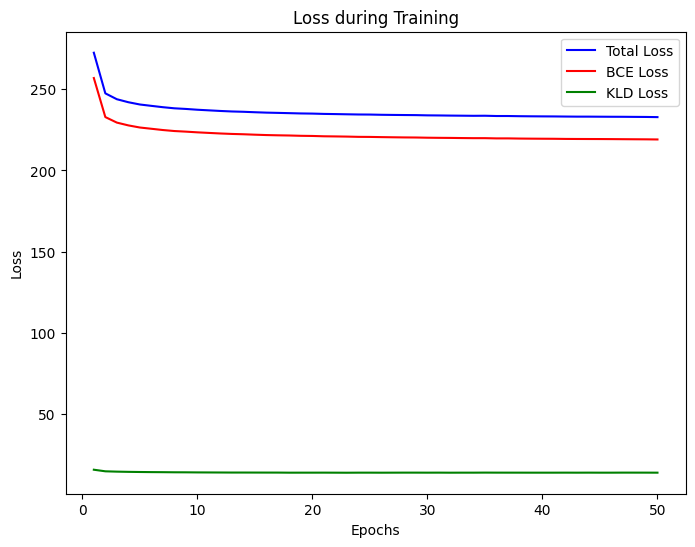

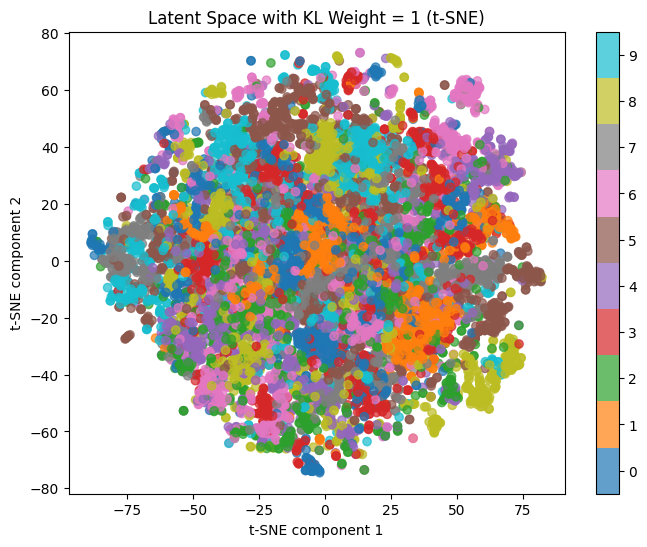


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 314.4346, BCE: 297.1528, KLD: 1.7282
Epoch 2: Average Loss: 289.4297, BCE: 273.0113, KLD: 1.6418
Epoch 3: Average Loss: 285.9730, BCE: 268.7554, KLD: 1.7218
Epoch 4: Average Loss: 283.7164, BCE: 265.8206, KLD: 1.7896
Epoch 5: Average Loss: 282.0997, BCE: 263.6964, KLD: 1.8403
Epoch 6: Average Loss: 281.1936, BCE: 262.4129, KLD: 1.8781
Epoch 7: Average Loss: 280.5167, BCE: 261.5574, KLD: 1.8959
Epoch 8: Average Loss: 279.9606, BCE: 260.8187, KLD: 1.9142
Epoch 9: Average Loss: 279.5248, BCE: 260.2781, KLD: 1.9247
Epoch 10: Average Loss: 279.2308, BCE: 259.7785, KLD: 1.9452
Epoch 11: Average Loss: 279.0386, BCE: 259.4408, KLD: 1.9598
Epoch 12: Average Loss: 278.8369, BCE: 259.0686, KLD: 1.9768
Epoch 13: Average Loss: 278.4681, BCE: 258.6895, KLD: 1.9779
Epoch 14: Average Loss: 278.3194, BCE: 258.3860, KLD: 1.9933
Epoch 15: Average Loss: 278.0845, BCE: 258.0882, KLD: 1.9996
Epoch 16: Average Loss: 277.9063, BCE: 257.8414, KLD: 2.0065

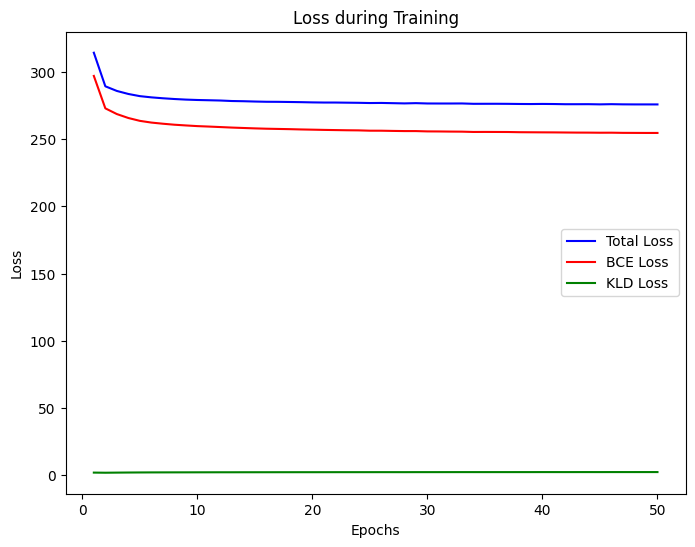

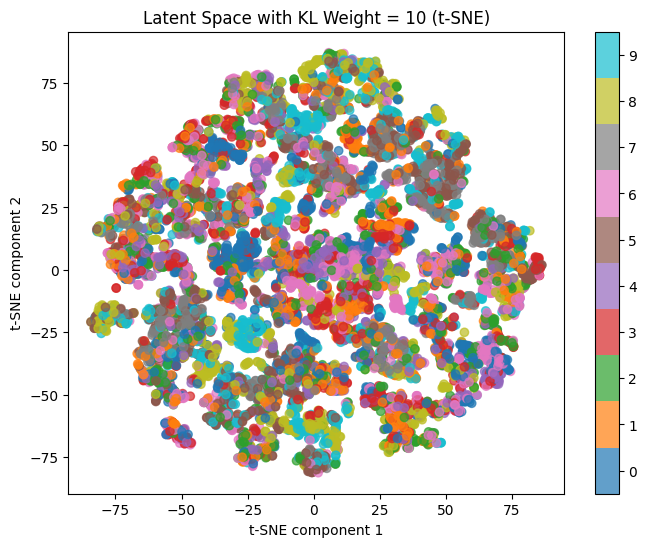


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 357.9656, BCE: 329.9703, KLD: 0.2800
Epoch 2: Average Loss: 311.5884, BCE: 309.8876, KLD: 0.0170
Epoch 3: Average Loss: 310.2475, BCE: 308.8413, KLD: 0.0141
Epoch 4: Average Loss: 309.7191, BCE: 308.4075, KLD: 0.0131
Epoch 5: Average Loss: 309.3222, BCE: 308.1950, KLD: 0.0113
Epoch 6: Average Loss: 309.0235, BCE: 307.9965, KLD: 0.0103
Epoch 7: Average Loss: 308.8136, BCE: 307.9427, KLD: 0.0087
Epoch 8: Average Loss: 308.5377, BCE: 307.8419, KLD: 0.0070
Epoch 9: Average Loss: 308.3703, BCE: 307.7627, KLD: 0.0061
Epoch 10: Average Loss: 308.1826, BCE: 307.6792, KLD: 0.0050
Epoch 11: Average Loss: 308.0765, BCE: 307.6700, KLD: 0.0041
Epoch 12: Average Loss: 307.9947, BCE: 307.6404, KLD: 0.0035
Epoch 13: Average Loss: 307.8099, BCE: 307.5340, KLD: 0.0028
Epoch 14: Average Loss: 307.8148, BCE: 307.5773, KLD: 0.0024
Epoch 15: Average Loss: 307.7040, BCE: 307.5030, KLD: 0.0020
Epoch 16: Average Loss: 307.6592, BCE: 307.5036, KLD: 0.001

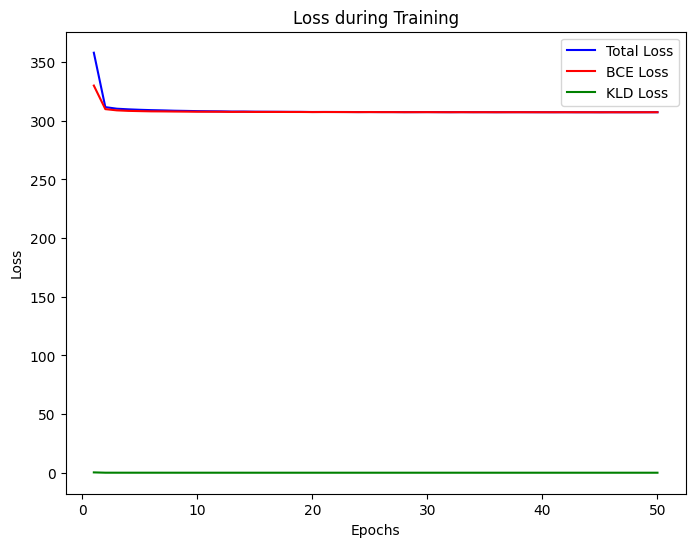

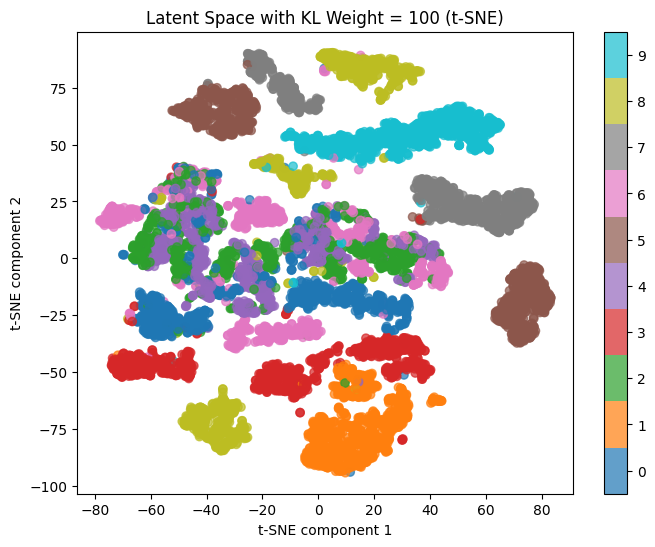

In [33]:
def train_and_plot_bis(kl_weight):
    # Créer un modèle avec 64 dimensions latentes
    model = ConvVAE(latent_dim=64).to(device)  # Latent dimension = 64
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    bce_losses = []
    kld_losses = []

    model.train()

    # Entraîner le modèle
    for epoch in range(epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function_sep(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        # Calculer les moyennes pour cette époque
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)

        # Stocker les valeurs pour la visualisation
        train_losses.append(average_loss)
        bce_losses.append(average_bce)
        kld_losses.append(average_kld)

        print(f'Epoch {epoch + 1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')

    # Visualisation de la perte pendant l'entraînement
    plot_loss(train_losses, bce_losses, kld_losses)

    # Visualisation de l'espace latent avec t-SNE
    plot_latent_space_bis(model, kl_weight)


def plot_latent_space_bis(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)

        # On encode les données et on récupère l'espace latent (mu)
        mu, logvar = model.encode(data, labels)
        z = mu.cpu().numpy()  # On utilise mu pour la visualisation (moyenne du VAE)

        # Réduction de la dimensionnalité de l'espace latent de 64D à 2D avec t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        z_tsne = tsne.fit_transform(z)  # On applique t-SNE pour réduire à 2 dimensions

        # Visualisation avec matplotlib
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=np.argmax(labels.cpu().numpy(), axis=1), cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight} (t-SNE)')
        plt.xlabel('t-SNE component 1')
        plt.ylabel('t-SNE component 2')
        plt.show()

# Maintenant, tu peux entraîner le modèle avec différents poids KL et visualiser les résultats
for kl_weight in [0.5, 1, 10, 100]:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot_bis(kl_weight)
